# Introduction
Here we compare the predicted growth range for the traning datasets using the iSG and the iAT601 model. Each model will be configured according the data set conditions.


## Model configurations
__iAT601 configurations__
- Cellulose
- Cellobiose

These conditions differ in GAM/NGAM values, and biomass objective function. The input and output fluxes will also be changed to default and measured values.

__iCBI configurations__
- GAM/NGAM
    - Chemostat cellulose
    - Chemostat cellobiose
    - Batch
- BOF
    - Cellulose 
    - Cellobiose
    
## Notes
iCBI is sometimes refered here as iSG

# Setup

In [1]:
%matplotlib inline
import sys
sys.path.append('../../')

import csv
from tools.conf_model import *
import cobra as cb
import settings
import pandas as pd

import matplotlib.pyplot as plt
# plot configuration
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
import string


In [2]:
# Models
isg = cb.io.load_json_model(os.path.join(settings.PROJECT_ROOT,'iCBI', 'iCBI655_cellobiose_batch.json'))

iat_cb = cb.io.read_sbml_model(os.path.join(settings.PROJECT_ROOT,"iAT601","iAT601_CB_fixed_GPR.xml"))
iat_ce = cb.io.read_sbml_model(os.path.join(settings.PROJECT_ROOT,"iAT601","iAT601_CE_fixed_GPR.xml"))

# Dataset
ds = pd.read_csv(settings.EXTRACELLULAR_FLUX_DATA)
ds.set_index('index', inplace=True)
ds.head()

,Strain,deleted_genes,Medium,Reference,Reactor,Notes,cellb,cellb_std,glceq,glceq_std,...,phe__L,phe__L_std,cell3,cell3_std,cell4,cell4_std,cell5,cell5_std,cell6,cell6_std
index,,,,,,,,,,,,,,,,,,,,,
0,WT,NaN,MTC-cellb,PMID26497628,Batch,NaN,-3.58,0.16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hydG,Clo1313_1571,MTC-cellb,PMID26497628,Batch,NaN,-3.43,0.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"hydG, ech","Clo1313_1571, Clo1313_0570-0575",MTC-cellb,PMID26497628,Batch,NaN,-4.33,0.62,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"hydG, pta-ack","Clo1313_1571, Clo1313_1185-1186",MTC-cellb,PMID26497628,Batch,NaN,-2.42,0.05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WT-ATCC27405,NaN,MTC-avcell,PMID26497628,Batch,Original data from PMID22350066,NaN,NaN,-6.39,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# iat has fixed exchanges for fermentation products this must be let open instead of fixed:
print('iat_cb')
for ex_rxn in iat_cb.exchanges:
    if ex_rxn.lower_bound > 0:
        print('\t Reaction: {} \t Original bounds: {} \t New bounds (0,1000)'.format(ex_rxn.name, ex_rxn.bounds))
        ex_rxn.bounds = (0,1000)
print('iat_ce')
for ex_rxn in iat_ce.exchanges:
    if ex_rxn.lower_bound > 0:
        print('\t Reaction: {} \t Original bounds: {} \t New bounds (0,1000)'.format(ex_rxn.name, ex_rxn.bounds))
        ex_rxn.bounds = (0,1000)
        
# It is fine for the substrate uptake to be unconstrained since it will be changed for each experimental datapoint

iat_cb
	 Reaction: EXC_IN_m20 	 Original bounds: (3.42, 3.48) 	 New bounds (0,1000)
	 Reaction: EXC_OUT_m51 	 Original bounds: (4.09, 4.29) 	 New bounds (0,1000)
	 Reaction: EXC_OUT_m52 	 Original bounds: (1.77, 3.49) 	 New bounds (0,1000)
	 Reaction: EXC_OUT_m53 	 Original bounds: (1.76, 1.78) 	 New bounds (0,1000)
	 Reaction: EXC_OUT_m55 	 Original bounds: (7.48, 8.24) 	 New bounds (0,1000)
iat_ce
	 Reaction: EXC_IN_m97 	 Original bounds: (1.0517, 1.078) 	 New bounds (0,1000)
	 Reaction: EXC_OUT_m51 	 Original bounds: (2.6, 2.66) 	 New bounds (0,1000)
	 Reaction: EXC_OUT_m52 	 Original bounds: (3.25, 3.55) 	 New bounds (0,1000)
	 Reaction: EXC_OUT_m53 	 Original bounds: (1.38, 1.39) 	 New bounds (0,1000)


# Define model setup functions

In [4]:
def calc_growth(model):
    try:
        max_bio = model.optimize().objective_value # Values near 0 correspond to infeasible solutions
        if max_bio < 1e-4:
            max_bio = np.nan
    except AttributeError as e:
        #raise e
        max_bio = np.nan
    return max_bio
    
def calc_isg_gr(ds, index):
    with isg as model:
        set_experimental_data(model, dataset_index=index, constraint_mode='both', reactor_type=ds.loc[index,'Reactor'], secretion='all')
        if 'cellb' in ds.loc[index, 'Medium']:
            set_bof(model, 'BIOMASS_CELLOBIOSE') # Note that set_bof resets the bounds of the biomass function to (0,1000)
        elif 'avcell' in ds.loc[index, 'Medium']:
            set_bof(model, 'BIOMASS_CELLULOSE')
        else:
            raise Exception('Medium cannot be identified for iSG. Index {} \t Medium {}'.format(index, ds.loc[index, 'Medium']))
        return calc_growth(model)

In [5]:
# ID map to iAT
df = pd.read_csv(os.path.join(settings.PROJECT_ROOT, 'iSG', 'reaction_nomenclature-curated.csv'))
isg2iat = dict(zip(df.isg_id,df.iat_id))
# special casses
isg2iat['ECH'] = 'R00019_c'
isg2iat['EX_gly_e'] = 'EXC_BOTH_m38'

def safe_nan_check(str_or_nan):
    if isinstance(str_or_nan,str):
        return False
    else:
        return np.isnan(str_or_nan) # will throw error if check is not valid
    
def delete_iat_genes(model, deleted_genes):
    if safe_nan_check(deleted_genes):
        mut_ko = []
    elif deleted_genes == 'Clo1313_1571':
        mut_ko = ['BIF','H2ASE_syn']
    elif deleted_genes == 'Clo1313_1571, Clo1313_0570-0575': 
        mut_ko = ['BIF','H2ASE_syn', 'ECH']
    elif deleted_genes == 'Clo1313_1571, Clo1313_1185-1186':
        mut_ko = ['BIF', 'H2ASE_syn', 'PTAr', 'ACKr']
    elif deleted_genes == 'Clo1313_0949':
        mut_ko = ['PPDK']
    else:
        raise Exception('Gene deletions for iAT could not be determined. Index: {} \t deleted_genes: {}'.format(index, deleted_genes))
    
    for rxn_id in mut_ko:
        if rxn_id in isg2iat:
            model.reactions.get_by_id(isg2iat[rxn_id]).bounds = (0, 0)
        else:
            print('Reaction: {} could not be matched to an iAT601 reaction'.format(rxn_id))

def setup_iat_exchanges(model, flux_row):
    met_ids = [i for i in flux_row.keys() if not i.endswith('std') and i not in ['index', 'Strain','deleted_genes', 'Medium', 'Reference', 'Reactor','Notes']]

    for met_id in met_ids:
        if met_id == 'GR':
            continue # We do not fix growth
           
        lb = abs(float(flux_row[met_id])) - float(flux_row[met_id + '_std']) # iAT does not follow convenction of exchange signs
        ub = abs(float(flux_row[met_id])) + float(flux_row[met_id + '_std'])
        
        if met_id == 'glceq':
        # For iAT cellulose EX_cell6 is changed, glucose equivalents are not functional. 
            lb = lb/6
            ub = ub/6
            met_id = 'cell6' 
        
        rxn_id = 'EX_{}_e'.format(met_id)
        if not (np.isnan(lb) or np.isnan(ub)):
            if rxn_id in isg2iat:
                #print('iSG/iAT rxn: {}/{} \t old bounds: {} \t new: {}'.format(rxn_id,isg2iat[rxn_id], model.reactions.get_by_id(isg2iat[rxn_id]).bounds, (lb, ub)))
                model.reactions.get_by_id(isg2iat[rxn_id]).bounds = (lb, ub)
                
            else:
                print('Reaction: {} could not be matched to an iAT601 reaction'.format(rxn_id))
                              
def calc_iat_gr(ds, index):
        if 'cellb' in ds.loc[index, 'Medium']:
            iat_mod = iat_cb
        elif 'avcell' in ds.loc[index, 'Medium']:
            iat_mod = iat_ce
        else:
            raise Exception('Medium for iAT could not be determined')
            
        with iat_mod as model:         
            delete_iat_genes(model, ds.loc[index, 'deleted_genes'])
            setup_iat_exchanges(model, ds.loc[index, :])      
            return calc_growth(model)
                


# Calculations

In [6]:
table_dict = []
for index, row in ds.iterrows():
    if not (row['Medium'] in ['MTC-cell3', 'MTC-cell4', 'MTC-cell5', 'MTC-cell6']): # Ignore c3-c6 cellodextrin as carbon sources
        isg_gr = calc_isg_gr(ds, index)
        iat_gr = calc_iat_gr(ds, index)
        table_dict.append(dict(index=index, Strain=row['Strain'], deleted_genes=row['deleted_genes'], Medium=row['Medium'],Reactor=row['Reactor'], GR=row['GR'], GR_str=row['GR_std'], isg_gr=isg_gr, iat_gr=iat_gr))
table = pd.DataFrame(table_dict)
table.set_index('index', inplace=True)

# Add an error term
table['iat_err'] = abs((table.iat_gr- table.GR)/table.GR)
table['isg_err'] = abs((table.isg_gr- table.GR)/table.GR)
table

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


Reaction: EX_g1p_e could not be matched to an iAT601 reaction
Reaction: EX_g1p_e could not be matched to an iAT601 reaction


,GR,GR_str,Medium,Reactor,Strain,deleted_genes,iat_gr,isg_gr,iat_err,isg_err
index,,,,,,,,,,
0,0.33,0.01,MTC-cellb,Batch,WT,NaN,0.343649,0.272094,0.041360,0.175474
1,0.24,0.02,MTC-cellb,Batch,hydG,Clo1313_1571,0.327134,0.270015,0.363058,0.125063
2,0.22,0.02,MTC-cellb,Batch,"hydG, ech","Clo1313_1571, Clo1313_0570-0575",NaN,0.335769,NaN,0.526224
3,0.16,0.02,MTC-cellb,Batch,"hydG, pta-ack","Clo1313_1571, Clo1313_1185-1186",0.182444,0.155993,0.140277,0.025047
4,0.31,0.01,MTC-avcell,Batch,WT-ATCC27405,NaN,0.305564,0.302990,0.014310,0.022613
5,0.39,0.04,AN7-cellb,Batch,WT,NaN,0.442404,0.354164,0.134369,0.091887
6,0.35,0.02,AN7-cellb,Batch,ppdk,Clo1313_0949,0.506098,0.403026,0.445995,0.151502
7,0.14,0.03,MTC-highavcell-clamped,Batch,WT,NaN,0.101965,0.109130,0.271681,0.220502
8,0.10,0.00,MTC-highavcell-vented,Batch,WT,NaN,0.215600,0.230877,1.156000,1.308769


# Plot error distributions for both models

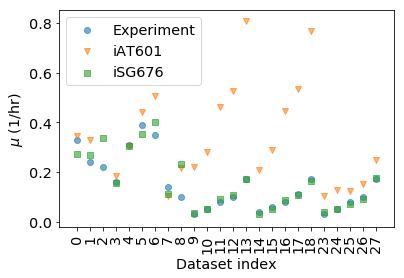

In [7]:
x =  np.arange(0,len(table.index))
plt.scatter(x, table.GR.values, alpha=0.6, label='Experiment')
plt.scatter(x, table.iat_gr.values, marker='v',alpha=0.6, label='iAT601')
plt.scatter(x, table.isg_gr.values, marker='s',alpha=0.6, label='iSG676')
plt.xticks(x, table.index, rotation='vertical');
plt.ylabel('$\mu$ (1/hr)')
plt.xlabel('Dataset index')
plt.legend(loc='upper left')

iAT predicts 0 better, since iat_cb is explicitely tranined to match this points.

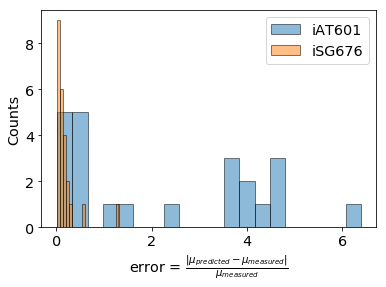

In [8]:
x = table.iat_err.dropna().values
y = table.isg_err.dropna().values


plt.hist(x, bins=20, alpha=0.5,  edgecolor='black', label='iAT601')
plt.hist(y, bins=20, alpha=0.5,  edgecolor='black', label='iSG676')
plt.legend(loc='upper right')
plt.ylabel('Counts')
plt.xlabel(r'error = $\frac{|\mu_{predicted} - \mu_{measured}|}{\mu_{measured}}$');

In [9]:
bt = table[table.Reactor == 'Batch']
ct = table[table.Reactor == 'Chemostat']
print('iSG batch error {:.2f} +- {:.2f}'.format(bt.isg_err.mean(), bt.isg_err.std()))
print('iAT batch error {:.2f} +- {:.2f}'.format(bt.iat_err.mean(), bt.iat_err.std()))
print('iSG chemostat error {:.2f} +- {:.2f}'.format(ct.isg_err.mean(), ct.isg_err.std()))
print('iAT chemostat error {:.2f} +- {:.2f}'.format(ct.iat_err.mean(), ct.iat_err.std()))

iSG batch error 0.29 +- 0.41
iAT batch error 0.32 +- 0.37
iSG chemostat error 0.10 +- 0.08
iAT chemostat error 3.28 +- 1.78


Interstingly iAT has lower mean batch error, but as we can see from the box plot, that is simply due to the outlier point.

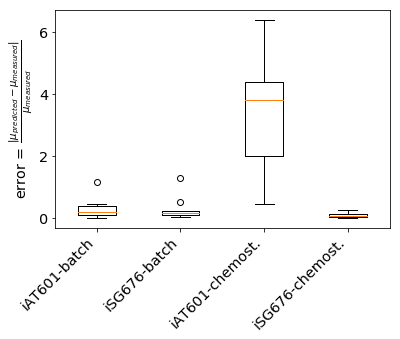

In [10]:
plt.boxplot([bt.iat_err.dropna().values,
             bt.isg_err.dropna().values,
             ct.iat_err.dropna().values,
             ct.isg_err.dropna().values]);
plt.xticks([1,2,3,4], ['iAT601-batch', 'iSG676-batch', 'iAT601-chemost.', 'iSG676-chemost.'], rotation=45, ha='right')
plt.ylabel(r'error = $\frac{|\mu_{predicted} - \mu_{measured}|}{\mu_{measured}}$');


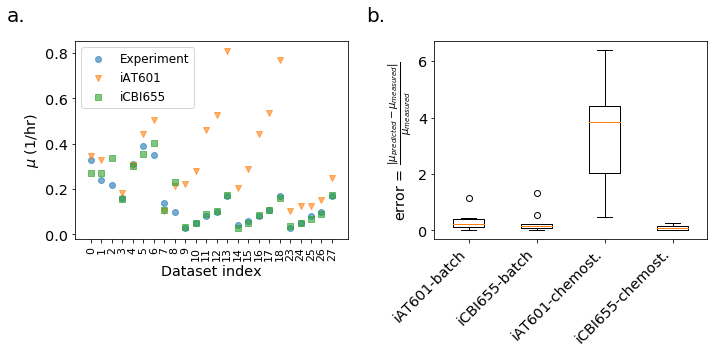

In [12]:
# Combined final plot
f, axs = plt.subplots(1, 2, figsize=(10,5))

x =  np.arange(0,len(table.index))
axs[0].scatter(x, table.GR.values, alpha=0.6, label='Experiment')
axs[0].scatter(x, table.iat_gr.values, marker='v',alpha=0.6, label='iAT601')
axs[0].scatter(x, table.isg_gr.values, marker='s',alpha=0.6, label='iCBI655')
#plt.xticks(x, table.index, rotation='vertical', ax=axs[0]);
axs[0].set_xticks(x)
axs[0].set_xticklabels(table.index, rotation=90, fontsize=11)
axs[0].set_ylabel('$\mu$ (1/hr)')
axs[0].set_xlabel('Dataset index')
axs[0].legend(loc='upper left', frameon=True, fontsize=12)
#axs[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.58), ncol=3, fontsize=12)
axs[1].boxplot([bt.iat_err.dropna().values,
             bt.isg_err.dropna().values,
             ct.iat_err.dropna().values,
             ct.isg_err.dropna().values]);
plt.xticks([1,2,3,4], ['iAT601-batch', 'iCBI655-batch', 'iAT601-chemost.', 'iCBI655-chemost.'], rotation=45, ha='right')
axs[1].set_ylabel(r'error = $\frac{|\mu_{predicted} - \mu_{measured}|}{\mu_{measured}}$');

#sns.despine()
for n, ax in enumerate(axs):
    ax.text(-0.25, 1.1, '{}.'.format(string.ascii_lowercase[n]), transform=ax.transAxes, 
            size=20)
plt.tight_layout(w_pad=2)
    
plt.subplots_adjust(bottom=0.3,top=0.85)
plt.savefig('growth-prediction-error.svg')
